In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [27]:
import os
os.chdir("/content")

In [28]:
# !cp /content/drive/MyDrive/code/mcl/medium.zip ./medium.zip
# !unzip -q medium.zip

^C
[medium.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of medium.zip or
        medium.zip.zip, and cannot find medium.zip.ZIP, period.


In [29]:
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import os
os.chdir("/content/drive/MyDrive/code/mcl")

In [31]:
from torch.utils.data import Dataset
import os
import json
from PIL import Image
import numpy as np
import torch
import clip
import copy
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [33]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [34]:
from numpy.core.arrayprint import printoptions
def load_single_profile(profile_data):
    data = profile_data
    optional_tags = data['optional_tags']
    _imgs_tags = data['imgs_tags']
    imgs_tags = dict()
    for p in _imgs_tags:
        imgs_tags.update(p)
    return optional_tags, imgs_tags

def load_translator(zh_file='./zh.txt', en_file='./en.txt'):
    with open(zh_file, 'r', encoding='utf8') as f:
            zh_words = f.read().splitlines()
        
    with open(en_file, 'r', encoding='utf8') as f:
            en_words = f.read().splitlines()
        
    return dict(zip(zh_words, en_words))

class Cloth_Dataset(Dataset):
    def __init__(self, isTrain=True, data_type='/content/medium', transform=None):
        super().__init__()
        self.isTrain = isTrain
        self.data_type = data_type
        self.transform = transform
        if isTrain: 
            profile_name = 'train_all.json'
            imag_name = 'train'
        else: 
            profile_name = 'test_all.json'
            imag_name = 'test'
        self.json_address = os.path.join(self.data_type, profile_name)
        self.imag_address = os.path.join(self.data_type, imag_name)
        self.alldata = self.load_profile(self.json_address, self.imag_address)
        model, self.preprocess = clip.load("ViT-B/32", device=device, jit=False)
        self.translator: dict = None
        self.translator = load_translator()

    # 将同文件夹的进行打包
    def load_profile(self, profile_path, img_path):
        with open(profile_path, 'r', encoding='UTF-8') as fp:
            all_data = json.load(fp)
        items = dict()
        for folder, data in all_data.items():
            optional_tags = data['optional_tags']
            imgs_tags = dict()
            for p in data['imgs_tags']:
                imgs_tags.update(p)
            items[folder] = ([(os.path.join(img_path, folder, img), tag) for img, tag in imgs_tags.items()], optional_tags)
        return items
    
    def __getitem__(self, index):
        processed_imgs = []
        processed_label = []
        en_optionaltags = []
        key = list(self.alldata.keys())[index]
        data, optional_tags = self.alldata[key]
        for img_path, tag in data:
            # encode picture
            img = Image.open(img_path).convert('RGB')
            img = self.preprocess(img)
            processed_imgs.append(img)
            # handle label
            ground_truth = np.zeros(len(optional_tags))
            for index, tags in enumerate(optional_tags):
                if tags == tag: ground_truth[index] = 1
                else: pass

            processed_label.append(ground_truth)
        # Tokenize the optional tags.
        # ToDo: be a sentence ???
        for text in optional_tags:
            text = self.translator[text]
            en_optionaltags.append(clip.tokenize(text))
        
        processed_label = np.array(processed_label)

        return (torch.stack(processed_imgs, 0), torch.cat(en_optionaltags, 0), torch.tensor(processed_label))

    def __len__(self):
        return len(self.alldata)

In [35]:
dataset = Cloth_Dataset(True, '/content/medium', None)

In [36]:
test_data = Cloth_Dataset(False, '/content/medium', None)
train_data, val_data = random_split(dataset, [int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)])

In [37]:
from torch import nn, optim
import numpy as np
import copy
import matplotlib.pyplot as plt

In [38]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float()

def load_pretrian_model(model_path):
    model, preprocess = clip.load(model_path, device=device, jit=False)  # 训练时 jit必须设置为false
    if device == "cpu":
        model.float()
    else:
        clip.model.convert_weights(model)
    return model, preprocess

def draw_curve(filename, loss, acc):
    plt.subplot(211)
    x=[i for i in range(len(loss))]
    plt.plot(x, loss, label='loss',linewidth=1,color='red')
    plt.legend()
    plt.subplot(212)
    plt.plot(x, acc, label='acc',linewidth=1,color='blue')
    plt.legend()
    plt.show()

def train(epochs, criterion, optimizer, train_loader, val_loader):
    train_acc_list = []
    loss_list = []
    for epoch in range(epochs):
        loss_sum = 0
        accu_num = 0
        length = 0
        for index, data in enumerate(train_loader):
            optimizer.zero_grad()

            images, optional_tags, labels = data
            images = torch.squeeze(images, dim=0)
            optional_tags = torch.squeeze(optional_tags, dim=0)
            labels = torch.squeeze(labels, dim=0)
            images = images.to(device)
            labels = labels.to(device)
            optional_tags = optional_tags.to(device)
            output = model(images, optional_tags)[0]

            loss = criterion(output,labels)
            loss.backward()

            optimizer.step()
            
            loss_sum += loss.cpu().item()
            predict = torch.argmax(output, dim=1)
            labels = torch.argmax(labels, dim=1)
            accu_num += (predict == labels).sum().item()
            length += images.shape[0]

        epoch_loss = loss_sum / length
        epoch_acc = accu_num / length
        val_acc = Test(val_loader, model)
        print('epoch: {} train loss: {:.6f}, train accuracy {:.6f}, val accuracy {:.6f}'.
              format(epoch + 1, epoch_loss, epoch_acc, val_acc))
        loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

    draw_curve('loss and acc curve', loss_list, train_acc_list)

    # save model
    # torch.save({
    #     'epoch': epoch,
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss': loss,
    #     }, f"model_checkpoint/model_10.pt") 

In [39]:
def Test(test_loader, model):
    acc_num = 0
    length = 0
    with torch.no_grad():
        for index, data in enumerate(test_loader):
            optimizer.zero_grad()

            images, optional_tags, labels = data
            images = torch.squeeze(images, dim=0)
            optional_tags = torch.squeeze(optional_tags, dim=0)
            labels = torch.squeeze(labels, dim=0)
            images = images.to(device)
            labels = labels.to(device)
            optional_tags = optional_tags.to(device)
            output = model(images, optional_tags)[0]

            predict = torch.argmax(output, dim=1)
            labels = torch.argmax(labels, dim=1)
            acc_num += (predict == labels).sum().item()
            length += images.shape[0]

    test_acc = acc_num / length
    print(test_acc)
    return test_acc

In [40]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

In [41]:
# train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
# print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

2160
5331


In [42]:
# Test(val_loader, model)

0.8602501359434476
epoch: 1 train loss: 0.058593, train accuracy 0.837194, val accuracy 0.860250
0.8716693855356172
epoch: 2 train loss: 0.051182, train accuracy 0.860219, val accuracy 0.871669
0.8822729744426319
epoch: 3 train loss: 0.046142, train accuracy 0.873437, val accuracy 0.882273
0.89015769439913
epoch: 4 train loss: 0.042415, train accuracy 0.883030, val accuracy 0.890158
0.898042414355628
epoch: 5 train loss: 0.039517, train accuracy 0.889994, val accuracy 0.898042


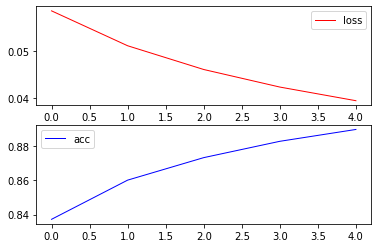

0.9019988895058301
epoch: 1 train loss: 0.039749, train accuracy 0.891261, val accuracy 0.901999
0.9058856191004997
epoch: 2 train loss: 0.037566, train accuracy 0.897636, val accuracy 0.905886
0.9086618545252637
epoch: 3 train loss: 0.035668, train accuracy 0.901218, val accuracy 0.908662
0.9097723486951693
epoch: 4 train loss: 0.034004, train accuracy 0.905229, val accuracy 0.909772
0.9122709605774569
epoch: 5 train loss: 0.032510, train accuracy 0.909456, val accuracy 0.912271


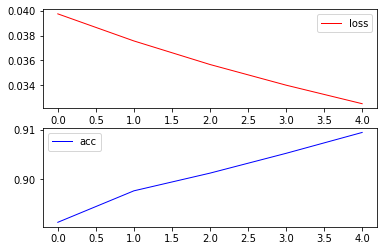

0.9157720891824938
epoch: 1 train loss: 0.032926, train accuracy 0.907501, val accuracy 0.915772
0.9168731076245528
epoch: 2 train loss: 0.031525, train accuracy 0.910546, val accuracy 0.916873
0.9174236168455822
epoch: 3 train loss: 0.030265, train accuracy 0.914158, val accuracy 0.917424
0.9176988714560969
epoch: 4 train loss: 0.029132, train accuracy 0.916071, val accuracy 0.917699
0.9174236168455822
epoch: 5 train loss: 0.028087, train accuracy 0.918620, val accuracy 0.917424


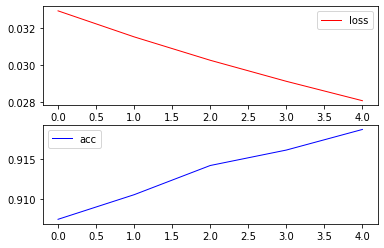

0.9182530795072789
epoch: 1 train loss: 0.032823, train accuracy 0.910120, val accuracy 0.918253
0.9202127659574468
epoch: 2 train loss: 0.031620, train accuracy 0.912701, val accuracy 0.920213
0.9204927211646137
epoch: 3 train loss: 0.030500, train accuracy 0.914994, val accuracy 0.920493
0.921612541993281
epoch: 4 train loss: 0.029460, train accuracy 0.917288, val accuracy 0.921613
0.9227323628219485
epoch: 5 train loss: 0.028508, train accuracy 0.919510, val accuracy 0.922732


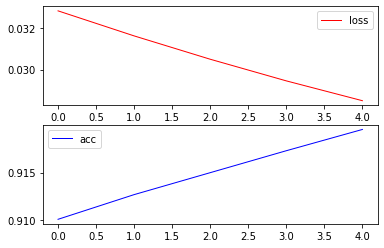

0.939452585015206
epoch: 1 train loss: 0.029426, train accuracy 0.921183, val accuracy 0.939453
0.9400055294442908
epoch: 2 train loss: 0.028471, train accuracy 0.924046, val accuracy 0.940006
0.9397290572297484
epoch: 3 train loss: 0.027580, train accuracy 0.925907, val accuracy 0.939729
0.9386231683715787
epoch: 4 train loss: 0.026774, train accuracy 0.927268, val accuracy 0.938623
0.9391761128006635
epoch: 5 train loss: 0.026006, train accuracy 0.929988, val accuracy 0.939176


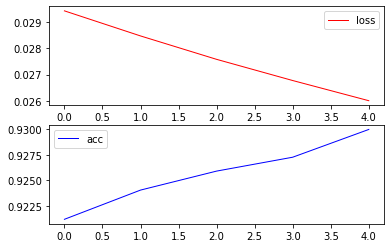

0.9285714285714286
epoch: 1 train loss: 0.027130, train accuracy 0.923954, val accuracy 0.928571
0.9282934963868816
epoch: 2 train loss: 0.026226, train accuracy 0.925582, val accuracy 0.928293
0.9291272929405225
epoch: 3 train loss: 0.025403, train accuracy 0.927777, val accuracy 0.929127
0.9316286826014453
epoch: 4 train loss: 0.024626, train accuracy 0.929902, val accuracy 0.931629
0.9330183435241801
epoch: 5 train loss: 0.023883, train accuracy 0.931459, val accuracy 0.933018


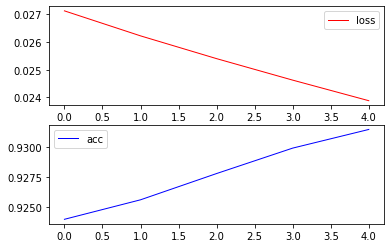

0.9286298011441024
epoch: 1 train loss: 0.028251, train accuracy 0.925672, val accuracy 0.928630
0.9280849904658132
epoch: 2 train loss: 0.027286, train accuracy 0.928030, val accuracy 0.928085
0.9269953691092345
epoch: 3 train loss: 0.026447, train accuracy 0.929317, val accuracy 0.926995
0.9272677744483792
epoch: 4 train loss: 0.025669, train accuracy 0.930675, val accuracy 0.927268
0.9283573958049578
epoch: 5 train loss: 0.024957, train accuracy 0.932604, val accuracy 0.928357


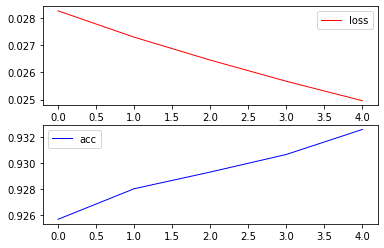

0.9274509803921569
epoch: 1 train loss: 0.023283, train accuracy 0.930799, val accuracy 0.927451
0.9277310924369748
epoch: 2 train loss: 0.022618, train accuracy 0.932650, val accuracy 0.927731
0.9294117647058824
epoch: 3 train loss: 0.022001, train accuracy 0.933504, val accuracy 0.929412
0.9302521008403362
epoch: 4 train loss: 0.021412, train accuracy 0.935284, val accuracy 0.930252
0.9291316526610645
epoch: 5 train loss: 0.020869, train accuracy 0.937278, val accuracy 0.929132


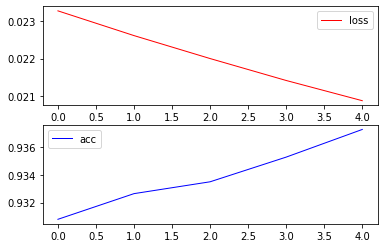

0.9249930805424855
epoch: 1 train loss: 0.025577, train accuracy 0.928429, val accuracy 0.924993
0.9249930805424855
epoch: 2 train loss: 0.024808, train accuracy 0.930070, val accuracy 0.924993
0.9255466371436479
epoch: 3 train loss: 0.024101, train accuracy 0.932211, val accuracy 0.925547
0.9252698588430667
epoch: 4 train loss: 0.023462, train accuracy 0.934066, val accuracy 0.925270
0.9255466371436479
epoch: 5 train loss: 0.022867, train accuracy 0.935993, val accuracy 0.925547


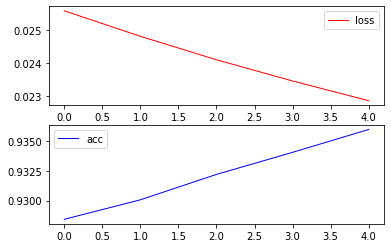

0.9360923423423423
epoch: 1 train loss: 0.023594, train accuracy 0.933423, val accuracy 0.936092
0.9369369369369369
epoch: 2 train loss: 0.022895, train accuracy 0.934552, val accuracy 0.936937
0.9375
epoch: 3 train loss: 0.022274, train accuracy 0.936035, val accuracy 0.937500
0.9383445945945946
epoch: 4 train loss: 0.021676, train accuracy 0.937235, val accuracy 0.938345
0.9397522522522522
epoch: 5 train loss: 0.021126, train accuracy 0.938718, val accuracy 0.939752


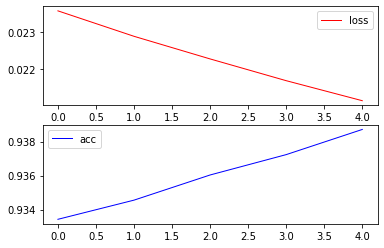

In [43]:
for i in range(10):
    small_train_data, _ = random_split(train_data, [int(len(train_data) * 0.1), len(train_data) - int(len(train_data) * 0.1)])
    small_val_data, _ = random_split(val_data, [500, len(val_data) - 500])
    small_train_loader = DataLoader(small_train_data, batch_size=1, shuffle=True)
    small_val_loader = DataLoader(small_val_data, batch_size=1, shuffle=True)
    train(5, criterion=criterion, optimizer=optimizer, train_loader=small_train_loader, val_loader=small_val_loader)

0.9441821716189948
epoch: 1 train loss: 0.022763, train accuracy 0.935270, val accuracy 0.944182
0.9444598722577062
epoch: 2 train loss: 0.022073, train accuracy 0.937672, val accuracy 0.944460
0.9455706748125521
epoch: 3 train loss: 0.021490, train accuracy 0.939298, val accuracy 0.945571
0.9458483754512635
epoch: 4 train loss: 0.020961, train accuracy 0.940358, val accuracy 0.945848
0.9458483754512635
epoch: 5 train loss: 0.020458, train accuracy 0.942124, val accuracy 0.945848


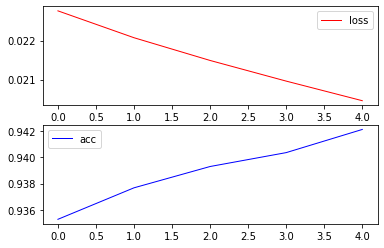

0.934435261707989
epoch: 1 train loss: 0.022149, train accuracy 0.941003, val accuracy 0.934435
0.9349862258953168
epoch: 2 train loss: 0.021563, train accuracy 0.942586, val accuracy 0.934986
0.9352617079889807
epoch: 3 train loss: 0.020997, train accuracy 0.943737, val accuracy 0.935262
0.9352617079889807
epoch: 4 train loss: 0.020488, train accuracy 0.945751, val accuracy 0.935262
0.9358126721763086
epoch: 5 train loss: 0.020010, train accuracy 0.946471, val accuracy 0.935813


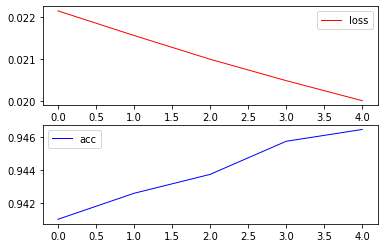

0.9296123178443773
epoch: 1 train loss: 0.019742, train accuracy 0.946017, val accuracy 0.929612
0.9293373659609568
epoch: 2 train loss: 0.019230, train accuracy 0.946726, val accuracy 0.929337
0.9309870772614792
epoch: 3 train loss: 0.018749, train accuracy 0.947507, val accuracy 0.930987
0.9298872697277977
epoch: 4 train loss: 0.018314, train accuracy 0.948925, val accuracy 0.929887
0.9309870772614792
epoch: 5 train loss: 0.017879, train accuracy 0.949635, val accuracy 0.930987


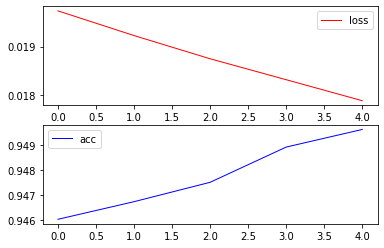

0.9378437843784379
epoch: 1 train loss: 0.020167, train accuracy 0.942921, val accuracy 0.937844
0.9381188118811881
epoch: 2 train loss: 0.019616, train accuracy 0.943711, val accuracy 0.938119
0.9378437843784379
epoch: 3 train loss: 0.019114, train accuracy 0.945793, val accuracy 0.937844
0.9367436743674368
epoch: 4 train loss: 0.018647, train accuracy 0.947157, val accuracy 0.936744
0.937018701870187
epoch: 5 train loss: 0.018217, train accuracy 0.948593, val accuracy 0.937019


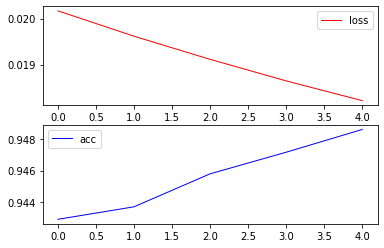

0.9387755102040817
epoch: 1 train loss: 0.019570, train accuracy 0.945121, val accuracy 0.938776
0.9390512961941533
epoch: 2 train loss: 0.019040, train accuracy 0.947185, val accuracy 0.939051
0.939327082184225
epoch: 3 train loss: 0.018550, train accuracy 0.947754, val accuracy 0.939327
0.9396028681742967
epoch: 4 train loss: 0.018084, train accuracy 0.949036, val accuracy 0.939603
0.9390512961941533
epoch: 5 train loss: 0.017646, train accuracy 0.950103, val accuracy 0.939051


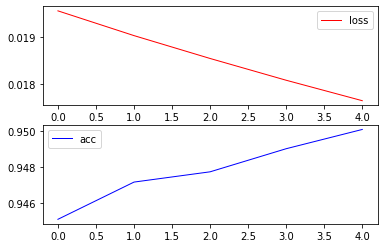

0.9428176795580111
epoch: 1 train loss: 0.019937, train accuracy 0.946701, val accuracy 0.942818
0.943646408839779
epoch: 2 train loss: 0.019396, train accuracy 0.947688, val accuracy 0.943646
0.9430939226519337
epoch: 3 train loss: 0.018925, train accuracy 0.948534, val accuracy 0.943094
0.9430939226519337
epoch: 4 train loss: 0.018473, train accuracy 0.949450, val accuracy 0.943094
0.9433701657458563
epoch: 5 train loss: 0.018054, train accuracy 0.950226, val accuracy 0.943370


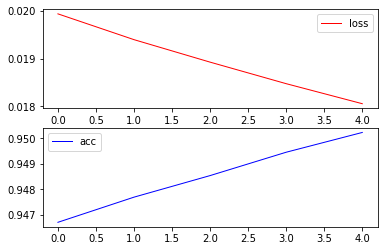

0.9463495575221239
epoch: 1 train loss: 0.018819, train accuracy 0.947740, val accuracy 0.946350
0.9463495575221239
epoch: 2 train loss: 0.018275, train accuracy 0.948868, val accuracy 0.946350
0.9463495575221239
epoch: 3 train loss: 0.017811, train accuracy 0.950138, val accuracy 0.946350
0.9457964601769911
epoch: 4 train loss: 0.017399, train accuracy 0.951478, val accuracy 0.945796
0.9449668141592921
epoch: 5 train loss: 0.017002, train accuracy 0.954017, val accuracy 0.944967


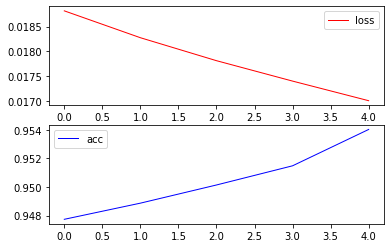

0.9406685236768803
epoch: 1 train loss: 0.019204, train accuracy 0.943442, val accuracy 0.940669
0.9395543175487465
epoch: 2 train loss: 0.018637, train accuracy 0.944631, val accuracy 0.939554
0.9403899721448468
epoch: 3 train loss: 0.018163, train accuracy 0.946449, val accuracy 0.940390
0.9417827298050139
epoch: 4 train loss: 0.017716, train accuracy 0.946728, val accuracy 0.941783
0.9417827298050139
epoch: 5 train loss: 0.017310, train accuracy 0.948476, val accuracy 0.941783


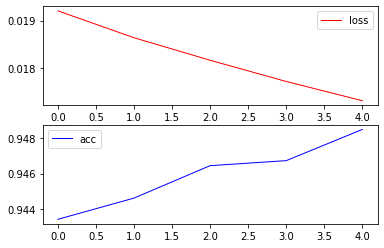

0.9452513966480447
epoch: 1 train loss: 0.018524, train accuracy 0.947698, val accuracy 0.945251
0.9452513966480447
epoch: 2 train loss: 0.017963, train accuracy 0.948625, val accuracy 0.945251
0.9458100558659218
epoch: 3 train loss: 0.017481, train accuracy 0.949409, val accuracy 0.945810
0.946927374301676
epoch: 4 train loss: 0.017041, train accuracy 0.951119, val accuracy 0.946927
0.9466480446927374
epoch: 5 train loss: 0.016649, train accuracy 0.952544, val accuracy 0.946648


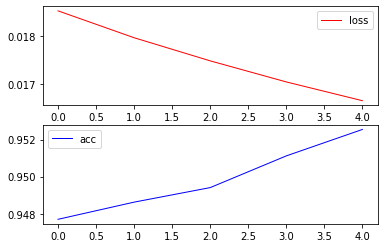

0.9406850459482038
epoch: 1 train loss: 0.019065, train accuracy 0.945900, val accuracy 0.940685
0.9409635199108883
epoch: 2 train loss: 0.018643, train accuracy 0.946685, val accuracy 0.940964
0.9401280980228348
epoch: 3 train loss: 0.018261, train accuracy 0.947613, val accuracy 0.940128
0.9404065719855194
epoch: 4 train loss: 0.017909, train accuracy 0.948826, val accuracy 0.940407
0.9395711500974658
epoch: 5 train loss: 0.017579, train accuracy 0.949468, val accuracy 0.939571


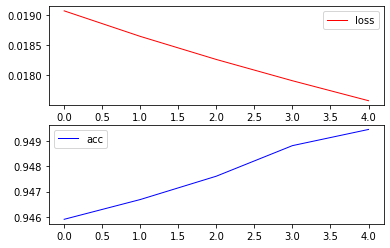

In [45]:
for i in range(10):
    small_train_data, _ = random_split(train_data, [int(len(train_data) * 0.1), len(train_data) - int(len(train_data) * 0.1)])
    small_val_data, _ = random_split(val_data, [500, len(val_data) - 500])
    small_train_loader = DataLoader(small_train_data, batch_size=1, shuffle=True)
    small_val_loader = DataLoader(small_val_data, batch_size=1, shuffle=True)
    train(5, criterion=criterion, optimizer=optimizer, train_loader=small_train_loader, val_loader=small_val_loader)

In [46]:
from tqdm import tqdm

In [47]:
def WriteAns(data_path="./medium/"):
        with open(os.path.join(data_path, 'test_all.json'), 'r', encoding='utf8') as f:
            data_list = json.load(f)
        with open('./zh.txt', 'r', encoding='utf8') as f:
            zh_words = f.read().splitlines()
        with open('./en.txt', 'r', encoding='utf8') as f:
            en_words = f.read().splitlines()
        translator = dict(zip(zh_words, en_words))
        with torch.no_grad():
            for key, value in tqdm(data_list.items()):
                img_list = []
                text_list = []
                tags = value["optional_tags"]
                pairs = value['imgs_tags']
                for tag in tags:
                    tag = translator[tag]
                    text_list.append(clip.tokenize(tag))
                
                for pair in pairs:
                    for img_path, label in pair.items():
                        img = Image.open(os.path.join(data_path, 'test', key, img_path))
                        img = preprocess(img)
                        img_list.append(img)
                
                img_list = torch.stack(img_list, 0).to(device)
                text_list = torch.cat(text_list, 0).to(device)
                # print(img_list.shape, text_list.shape)
                output = model(img_list, text_list)[0]
                pred = torch.argmax(output, 1)

                for i, p in enumerate(pairs):
                    data_list[key]['imgs_tags'][i][list(p.keys())[0]] = tags[pred[i].item()]
        with open('test_all.json', 'w', encoding='utf8') as f:
            json.dump(data_list, f, ensure_ascii=False, indent=4)

In [48]:
WriteAns('/content/medium')

100%|██████████| 5331/5331 [03:28<00:00, 25.54it/s]


0.937089715536105
epoch: 1 train loss: 0.016685, train accuracy 0.952788, val accuracy 0.937090
0.937089715536105
epoch: 2 train loss: 0.016238, train accuracy 0.954426, val accuracy 0.937090
0.936542669584245
epoch: 3 train loss: 0.015855, train accuracy 0.955138, val accuracy 0.936543
0.937636761487965
epoch: 4 train loss: 0.015485, train accuracy 0.956420, val accuracy 0.937637
0.937636761487965
epoch: 5 train loss: 0.015150, train accuracy 0.957844, val accuracy 0.937637


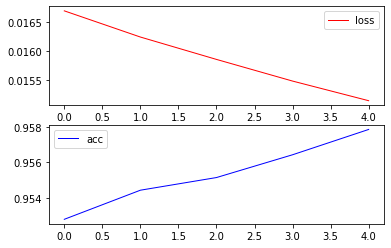

0.9467190128996074
epoch: 1 train loss: 0.017032, train accuracy 0.951896, val accuracy 0.946719
0.947279865395401
epoch: 2 train loss: 0.016604, train accuracy 0.952821, val accuracy 0.947280
0.9478407178911946
epoch: 3 train loss: 0.016225, train accuracy 0.953747, val accuracy 0.947841
0.9478407178911946
epoch: 4 train loss: 0.015880, train accuracy 0.955312, val accuracy 0.947841
0.9467190128996074
epoch: 5 train loss: 0.015546, train accuracy 0.956379, val accuracy 0.946719


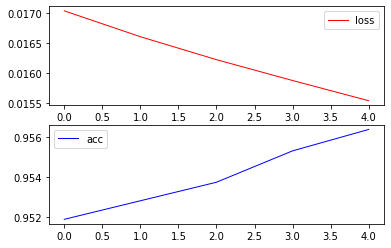

0.9525377229080932
epoch: 1 train loss: 0.017636, train accuracy 0.950983, val accuracy 0.952538
0.9528120713305899
epoch: 2 train loss: 0.017211, train accuracy 0.951761, val accuracy 0.952812
0.9525377229080932
epoch: 3 train loss: 0.016840, train accuracy 0.953176, val accuracy 0.952538


KeyboardInterrupt: ignored

In [49]:
for i in range(5):
    small_train_data, _ = random_split(train_data, [int(len(train_data) * 0.1), len(train_data) - int(len(train_data) * 0.1)])
    small_val_data, _ = random_split(val_data, [500, len(val_data) - 500])
    small_train_loader = DataLoader(small_train_data, batch_size=1, shuffle=True)
    small_val_loader = DataLoader(small_val_data, batch_size=1, shuffle=True)
    train(5, criterion=criterion, optimizer=optimizer, train_loader=small_train_loader, val_loader=small_val_loader)

In [50]:
torch.save(model, './model_4.pt')

In [51]:
WriteAns('/content/medium')

100%|██████████| 5331/5331 [03:27<00:00, 25.70it/s]


In [ ]:
# for i in range(30):
#     small_train_data, _ = random_split(train_data, [int(len(train_data) * 0.1), len(train_data) - int(len(train_data) * 0.1)])
#     small_val_data, _ = random_split(val_data, [500, len(val_data) - 500])
#     small_train_loader = DataLoader(small_train_data, batch_size=1, shuffle=True)
#     small_val_loader = DataLoader(small_val_data, batch_size=1, shuffle=True)
#     train(5, criterion=criterion, optimizer=optimizer, train_loader=small_train_loader, val_loader=small_val_loader)